## Подготовка данных

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import pandas as pd

In [3]:
df = pd.read_csv("https://storage.yandexcloud.net/auth-def-2024/datasets/meta_table_with_texts.csv")

In [4]:
df = df[['author', 'text']]
df.head(5)

,author,text
0,Пушкин Александр Сергеевич,"\n \nЛитературный альбомъ.\n""Сраженный рыцар..."
1,Карамзин Николай Михайлович,\nО достоинстве древних и новых\n(Перевод с не...
2,Гоголь Николай Васильевич,\n Гоголь Н. В. Полное собрание сочинений и ...
3,Мамин-Сибиряк Дмитрий Наркисович,\n \nД. МАМИНЪ-СИБИРЯКЪПОЛНОЕ СОБРАНІЕ СОЧИН...
4,Мамин-Сибиряк Дмитрий Наркисович,\nДмитрий Мамин-Сибиряк\nНимфа\nI.\n Щегольс...


### Расчет эвристик

*Примечание: в ходе расчетов могут дублироваться функции обработки текста, разработанные на этапе EDA.<br>*
Прежде, чем рассчитывать эвристики, почистим текст от нежелательных пробельных символов, а также некорректных unicode-символов:

In [5]:
import re

def clean_df(x):
  # Удаление unicode-символов
  x = re.sub(r'&#\d+;|&#x[0-9a-fA-F]+;', '', x)
  x = x.replace('\n', ' ')
  v2 = re.sub(r'[^А-Яа-я0-9\(\).,!?: \-]', '', x.lower())
  result = re.sub(r'\s+', ' ', v2).strip()
  return result

In [6]:
df['clean_text'] = df['text'].apply(clean_df)

In [7]:
df.head(5)

,author,text,clean_text
0,Пушкин Александр Сергеевич,"\n \nЛитературный альбомъ.\n""Сраженный рыцар...",литературный альбомъ. сраженный рыцарь. пушкин...
1,Карамзин Николай Михайлович,\nО достоинстве древних и новых\n(Перевод с не...,о достоинстве древних и новых (перевод с немец...
2,Гоголь Николай Васильевич,\n Гоголь Н. В. Полное собрание сочинений и ...,гоголь н. в. полное собрание сочинений и писем...
3,Мамин-Сибиряк Дмитрий Наркисович,\n \nД. МАМИНЪ-СИБИРЯКЪПОЛНОЕ СОБРАНІЕ СОЧИН...,д. маминъ-сибирякъполное собране сочиненйтомъ ...
4,Мамин-Сибиряк Дмитрий Наркисович,\nДмитрий Мамин-Сибиряк\nНимфа\nI.\n Щегольс...,дмитрий мамин-сибиряк нимфа . щегольской волжс...


In [8]:
major_class = df['author'].value_counts().idxmax()
major_class

'Куприн Александр Иванович'

#### Lexicon-based эвристики

Начнем с **Lexicon-based** для определения тональности и субъективности текста.

In [9]:
from textblob import TextBlob

# Тональность текста
df['tonality'] = df['clean_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
# Субъективность текста
df['subjectivity'] = df['clean_text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

Также рассмотрим вероятность токстичности текста с помощью предобученной модели `unitary/toxic-bert`:

In [ ]:
from transformers import AutoTokenizer, pipeline

tokenizer = AutoTokenizer.from_pretrained("unitary/toxic-bert")
toxicity_model = pipeline("text-classification", model="unitary/toxic-bert", tokenizer="unitary/toxic-bert")

# Функция для сокращения текста в случае превышения лимита токенов (512)
# Исключаем специальные токены [CLS] и [SEP]
def truncate_text(text, max_length=510):
    tokens = tokenizer.tokenize(text)
    truncated_tokens = tokens[:max_length]
    return tokenizer.convert_tokens_to_string(truncated_tokens)

# Функция вычисления токсичности текста
def predict_toxicity(text):
    result = toxicity_model(text)
    return result[0]['score'] if result[0]['label'] == "LABEL_1" else 0


df['toxicity_score'] = df['clean_text'].apply(lambda x: predict_toxicity(truncate_text(x)))

In [31]:
df[df['toxicity_score'] != 0]

,author,text,tonality,subjectivity,toxicity_score


In [ ]:
df = df.drop('toxicity_score', axis = 1)

Как видим, в нашем датасете не было выявлено токсичности, поэтому данный признак не имеет смысла рассматривать в модели.

Мы вычислим в качестве стилистических эвристик средние значения для каждого автора, чтобы избежать шумов в рамках отдельных текстов и упростить анализ. Это связано с тем, что такие признаки, как тональность и субъективночть лучше обобщать, группируя по авторам.

In [10]:
lexicon_based = df.groupby('author')[['tonality', 'subjectivity']].mean().reset_index()
lexicon_based.columns = ['author', 'avg_tonality', 'avg_subjectivity']
lexicon_based

,author,avg_tonality,avg_subjectivity
0,Блок Александр Александрович,-0.017413,0.169492
1,Бунин Иван Алексеевич,-0.029276,0.098712
2,Гоголь Николай Васильевич,-0.010425,0.195767
3,Достоевский Федор Михайлович,-0.045390,0.415000
4,Есенин Сергей Александрович,0.017770,0.088235
5,Карамзин Николай Михайлович,-0.232829,0.358885
6,Куприн Александр Иванович,-0.001769,0.030769
7,Лермонтов Михаил Юрьевич,-0.041284,0.135135
8,Мамин-Сибиряк Дмитрий Наркисович,-0.000427,0.007812
9,Пушкин Александр Сергеевич,0.066585,0.229008


In [11]:
df = df.merge(lexicon_based, on='author', how='left')

#### Rule-based эвристики

Теперь посчитаем **Rule-based** эвристики, начнем с определения сложности текстов.

In [ ]:
!pip install textstat

In [13]:
import textstat

# Оценка сложности текста
df['complexity'] = df['clean_text'].apply(textstat.flesch_reading_ease)

Также рассчитаем ряд числовых признаков:

In [14]:
def avg_and_total_words(text):
    # Разделение текста на предложения
    sentences = re.split(r'[.!?]', text)
    sentences = [s.strip() for s in sentences if s.strip()]

    # Подсчёт слов в тексте
    words = re.findall(r'\b\w+\b', text)
    total_words = len(words)

    # Подсчёт слов в каждом предложении
    words_per_sentence = [len(re.findall(r'\b\w+\b', sentence)) for sentence in sentences]

    # Среднее количество слов в предложении
    avg_words = sum(words_per_sentence) / len(sentences) if sentences else 0

    return total_words, avg_words

In [15]:
# Длина текста
df['len_symbols'] = df['clean_text'].apply(len)
# Общее кол-во слов/ среднее кол-во слов в предложении
df[['total_words', 'avg_words_per_sentence']] = df['clean_text'].apply(lambda x: pd.Series(avg_and_total_words(x)))

In [17]:
df['total_words'] = df['total_words'].apply(int)

#### Корреляционная матрица

После расчета эвристик следует убедиться, что между ними не присутствует сильной заивисимости во избежание проблемы мультиколлинеарности. Построим тепловую карту для наглядности:

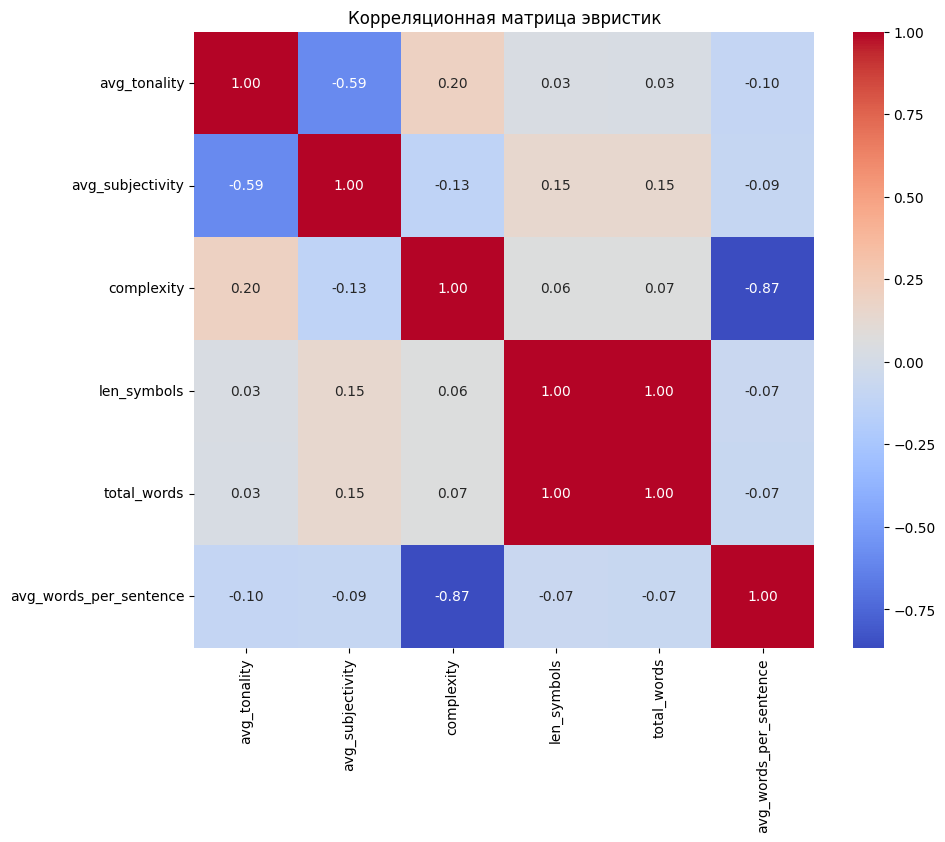

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns


heuristics = ['avg_tonality', 'avg_subjectivity', 'complexity', 'len_symbols', 'total_words', 'avg_words_per_sentence']
df_heuristics = df[heuristics]

# Построение тепловой карты
plt.figure(figsize=(10, 8))
sns.heatmap(df_heuristics.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Корреляционная матрица эвристик')
plt.show()

Мы видим, что между `len_symbols` и `total_words` наблюдается полная прямая зависимость, оба признака характеризуют размер текста. Оставим `total_words`, так как признак является более интерпретируемым.<br>
Высокая обратная зависимость наблюдается между `avg_words_per_sentence` и `complexity`. Чем меньше слов в предложении, тем выше значение `complexity`, а значит текст читается проще. Оставим признак `avg_words_per_sentence`, так как он более интерпретируем.<br>
Значения корреляции в $0.59$ между `avg_tonality` и `avg_subjectivity` посчитаем допустимым (будем рассматривать условный порог в $0.7$). К тому же признаки означают достаточно разные характеристики текста, поэтому не будем их исключать из перечня эвристик.

In [19]:
heuristics = ['avg_tonality', 'avg_subjectivity', 'total_words', 'avg_words_per_sentence']

### Подготовка выборок

In [21]:
# Разбиваем выборки
X_text = df['clean_text']
X_heuristics = df[heuristics]
y = df['author']

Для векторизации выберем $BoW$

In [24]:
# Преобразование текстов в численное представление с помощью CountVectorizer
vectorizer_bow = CountVectorizer(ngram_range=(1, 2), max_features=500)  # Учитываем униграммы и биграммы
X_bow = vectorizer_bow.fit_transform(X_text)

In [25]:
print(X_bow.shape)

(2565, 500)


> Для наших текстов `CountVectorizer` сделал 500 features (500 колонок).

По сути есть подхода к обучению моделей:
- только на эвристиках,
- только на текстовых признаках,
- комбинированный подход.

Так что на этапе обучения модели будем рассматривать все возможные подходы.

### Обучение трех разных моделей и их метрики (baseline)

#### Только эвристики

In [88]:
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X_heuristics, y, test_size=0.2, random_state=42)

# Числовые признаки лучше стандартизировать
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [89]:
import numpy as np

y_pred_random = np.random.choice(np.unique(y_test), size=len(y_test))
# Оценка точности случайного предсказания
accuracy_random = accuracy_score(y_test, y_pred_random)
print(f"Accuracy (Random Baseline): {accuracy_random:.2f}")

Accuracy (Random Baseline): 0.09


In [90]:
# Инициализация и обучение моделей
model_SVC = SVC(kernel='linear', random_state=42)
model_logreg = LogisticRegression(random_state=42, max_iter=1000)
model_dt = DecisionTreeClassifier(max_depth=5, random_state=42)

model_SVC.fit(X_train_scaled, y_train)
model_logreg.fit(X_train_scaled, y_train)
model_dt.fit(X_train_scaled, y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [91]:
# Предсказания
y_pred_SVC = model_SVC.predict(X_test_scaled)
y_pred_logreg = model_logreg.predict(X_test_scaled)
y_pred_dt = model_dt.predict(X_test_scaled)

##### Метрики качества

###### SVC

In [92]:
# Оценка качества модели
# Accuracy
accuracy = accuracy_score(y_test, y_pred_SVC)
print("Accuracy:", accuracy)

# Precision, Recall, F1 (взвешенные для многоклассовой задачи)
precision = precision_score(y_test, y_pred_SVC, average='weighted')
recall = recall_score(y_test, y_pred_SVC, average='weighted')
f1 = f1_score(y_test, y_pred_SVC, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Матрица ошибок
conf_matrix = confusion_matrix(y_test, y_pred_SVC)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
 [[21  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 50  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 38  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 45  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 13  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 59  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 78  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  7  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 53  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 28  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 36  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 61  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 24]]


In [93]:
# Полный отчет
print("\nClassification Report:")
print(classification_report(y_test, y_pred_SVC))


Classification Report:
                                   precision    recall  f1-score   support

     Блок Александр Александрович       1.00      1.00      1.00        21
            Бунин Иван Алексеевич       1.00      1.00      1.00        50
        Гоголь Николай Васильевич       1.00      1.00      1.00        38
     Достоевский Федор Михайлович       1.00      1.00      1.00        45
      Есенин Сергей Александрович       1.00      1.00      1.00        13
      Карамзин Николай Михайлович       1.00      1.00      1.00        59
        Куприн Александр Иванович       1.00      1.00      1.00        78
         Лермонтов Михаил Юрьевич       1.00      1.00      1.00         7
 Мамин-Сибиряк Дмитрий Наркисович       1.00      1.00      1.00        53
       Пушкин Александр Сергеевич       1.00      1.00      1.00        28
Салтыков-Щедрин Михаил Евграфович       1.00      1.00      1.00        36
          Тургенев Иван Сергеевич       1.00      1.00      1.00        61


###### LogisticRegression

In [94]:
# Оценка качества модели
# Accuracy
accuracy = accuracy_score(y_test, y_pred_logreg)
print("Accuracy:", accuracy)

# Precision, Recall, F1 (взвешенные для многоклассовой задачи)
precision = precision_score(y_test, y_pred_logreg, average='weighted')
recall = recall_score(y_test, y_pred_logreg, average='weighted')
f1 = f1_score(y_test, y_pred_logreg, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Матрица ошибок
conf_matrix = confusion_matrix(y_test, y_pred_logreg)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.9005847953216374
Precision: 0.8895198263549933
Recall: 0.9005847953216374
F1 Score: 0.8919118407025997
Confusion Matrix:
 [[ 8  0 13  0  0  0  0  0  0  0  0  0  0]
 [ 0 50  0  0  0  0  0  0  0  0  0  0  0]
 [ 5  0 22  0  0  0  0  0  0  0  0  0 11]
 [ 0  0  0 45  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  9  0  4  0  0  0  0  0  0]
 [ 0  0  0  0  0 59  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 76  0  2  0  0  0  0]
 [ 0  7  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  5  0 48  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 28  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 36  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 61  0]
 [ 0  0  4  0  0  0  0  0  0  0  0  0 20]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [95]:
# Полный отчет
print("\nClassification Report:")
print(classification_report(y_test, y_pred_logreg))


Classification Report:
                                   precision    recall  f1-score   support

     Блок Александр Александрович       0.62      0.38      0.47        21
            Бунин Иван Алексеевич       0.88      1.00      0.93        50
        Гоголь Николай Васильевич       0.56      0.58      0.57        38
     Достоевский Федор Михайлович       1.00      1.00      1.00        45
      Есенин Сергей Александрович       1.00      0.69      0.82        13
      Карамзин Николай Михайлович       1.00      1.00      1.00        59
        Куприн Александр Иванович       0.89      0.97      0.93        78
         Лермонтов Михаил Юрьевич       0.00      0.00      0.00         7
 Мамин-Сибиряк Дмитрий Наркисович       0.96      0.91      0.93        53
       Пушкин Александр Сергеевич       1.00      1.00      1.00        28
Салтыков-Щедрин Михаил Евграфович       1.00      1.00      1.00        36
          Тургенев Иван Сергеевич       1.00      1.00      1.00        61


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


###### DecisionTreeClassifier

In [96]:
# Оценка качества модели
# Accuracy
accuracy = accuracy_score(y_test, y_pred_dt)
print("Accuracy:", accuracy)

# Precision, Recall, F1 (взвешенные для многоклассовой задачи)
precision = precision_score(y_test, y_pred_dt, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred_dt, average='weighted')
f1 = f1_score(y_test, y_pred_dt, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Матрица ошибок
conf_matrix = confusion_matrix(y_test, y_pred_dt)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.7485380116959064
Precision: 0.6800870353271091
Recall: 0.7485380116959064
F1 Score: 0.6965201375213945
Confusion Matrix:
 [[ 0  0 21  0  0  0  0  0  0  0  0  0  0]
 [ 0 50  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 38  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 45  0  0  0  0  0  0  0  0  0]
 [ 0  0 13  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 59  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 78  0  0  0  0  0  0]
 [ 0  7  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 53  0  0  0  0]
 [ 0  0 28  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 36  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 61  0]
 [ 0  0 24  0  0  0  0  0  0  0  0  0  0]]


In [97]:
# Полный отчет
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt, zero_division=0))


Classification Report:
                                   precision    recall  f1-score   support

     Блок Александр Александрович       0.00      0.00      0.00        21
            Бунин Иван Алексеевич       0.88      1.00      0.93        50
        Гоголь Николай Васильевич       0.24      1.00      0.38        38
     Достоевский Федор Михайлович       1.00      1.00      1.00        45
      Есенин Сергей Александрович       0.00      0.00      0.00        13
      Карамзин Николай Михайлович       1.00      1.00      1.00        59
        Куприн Александр Иванович       1.00      1.00      1.00        78
         Лермонтов Михаил Юрьевич       0.00      0.00      0.00         7
 Мамин-Сибиряк Дмитрий Наркисович       1.00      1.00      1.00        53
       Пушкин Александр Сергеевич       0.00      0.00      0.00        28
Салтыков-Щедрин Михаил Евграфович       0.00      0.00      0.00        36
          Тургенев Иван Сергеевич       1.00      1.00      1.00        61


##### Сводка по метрикам качества

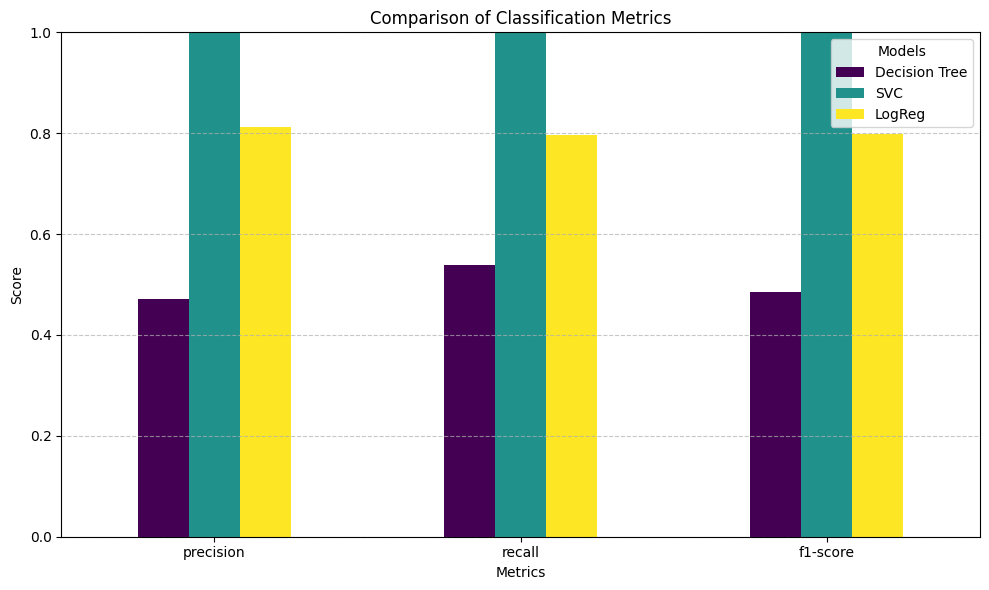

In [98]:
import matplotlib.pyplot as plt

report_dt = classification_report(y_test, y_pred_dt, output_dict=True, zero_division=0)
report_svc = classification_report(y_test, y_pred_SVC, output_dict=True, zero_division=0)
report_logreg = classification_report(y_test, y_pred_logreg, output_dict=True, zero_division=0)

# Выбираем метрики для визуализации
metrics = ['precision', 'recall', 'f1-score']
labels = ['Decision Tree', 'SVC', 'LogReg']

# Извлечение метрик
data = {
    'Decision Tree': [report_dt['macro avg'][metric] for metric in metrics],
    'SVC': [report_svc['macro avg'][metric] for metric in metrics],
    'LogReg': [report_logreg['macro avg'][metric] for metric in metrics]
}

# Создание DataFrame для удобства работы
df = pd.DataFrame(data, index=metrics)

# Построение гистограммы
df.plot(kind='bar', figsize=(10, 6), colormap='viridis')
plt.title('Comparison of Classification Metrics')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(title='Models')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### Только текстовые признаки

In [56]:
# Только текстовые признаки
X_train, X_test, y_train, y_test = train_test_split(X_bow, y, test_size=0.2, random_state=42)

In [61]:
y_pred_random = np.random.choice(np.unique(y_test), size=len(y_test))
# Оценка точности случайного предсказания
accuracy_random = accuracy_score(y_test, y_pred_random)
print(f"Accuracy (Random Baseline): {accuracy_random:.2f}")

Accuracy (Random Baseline): 0.07


In [62]:
model_SVC = SVC(kernel='linear', random_state=42)
model_logreg = LogisticRegression(random_state=42, max_iter=1000)
model_dt = DecisionTreeClassifier(max_depth=5, random_state=42)

model_SVC.fit(X_train, y_train)
model_logreg.fit(X_train, y_train)
model_dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [63]:
# Предсказания
y_pred_SVC = model_SVC.predict(X_test)
y_pred_logreg = model_logreg.predict(X_test)
y_pred_dt = model_dt.predict(X_test)

##### Метрики качества:

###### SVC

In [64]:
# Оценка качества модели
# Accuracy
accuracy = accuracy_score(y_test, y_pred_SVC)
print("Accuracy:", accuracy)

# Precision, Recall, F1 (взвешенные для многоклассовой задачи)
precision = precision_score(y_test, y_pred_SVC, average='weighted')
recall = recall_score(y_test, y_pred_SVC, average='weighted')
f1 = f1_score(y_test, y_pred_SVC, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Матрица ошибок
conf_matrix = confusion_matrix(y_test, y_pred_SVC)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.7543859649122807
Precision: 0.7786110078011186
Recall: 0.7543859649122807
F1 Score: 0.7610628294430676
Confusion Matrix:
 [[12  1  0  0  2  0  4  0  0  0  1  0  1]
 [ 1 41  0  0  1  0  3  0  1  1  1  1  0]
 [ 7  0 23  1  0  2  1  1  0  0  2  1  0]
 [ 1  1  0 34  0  3  3  0  0  0  3  0  0]
 [ 1  2  0  0  5  0  2  0  0  1  0  0  2]
 [ 2  0  0  0  1 47  1  2  3  1  0  2  0]
 [ 4  5  1  0  3  1 60  1  2  0  0  0  1]
 [ 0  0  0  0  0  1  0  4  1  0  0  1  0]
 [ 0  0  0  1  0  0  3  0 48  0  1  0  0]
 [ 3  1  0  0  3  1  0  1  0 19  0  0  0]
 [ 1  0  0  2  1  1  2  0  0  0 28  1  0]
 [ 2  1  1  1  1  2  0  2  1  0  0 50  0]
 [ 0  3  0  0  0  2  1  0  0  1  1  0 16]]


In [65]:
# Полный отчет
print("\nClassification Report:")
print(classification_report(y_test, y_pred_SVC))


Classification Report:
                                   precision    recall  f1-score   support

     Блок Александр Александрович       0.35      0.57      0.44        21
            Бунин Иван Алексеевич       0.75      0.82      0.78        50
        Гоголь Николай Васильевич       0.92      0.61      0.73        38
     Достоевский Федор Михайлович       0.87      0.76      0.81        45
      Есенин Сергей Александрович       0.29      0.38      0.33        13
      Карамзин Николай Михайлович       0.78      0.80      0.79        59
        Куприн Александр Иванович       0.75      0.77      0.76        78
         Лермонтов Михаил Юрьевич       0.36      0.57      0.44         7
 Мамин-Сибиряк Дмитрий Наркисович       0.86      0.91      0.88        53
       Пушкин Александр Сергеевич       0.83      0.68      0.75        28
Салтыков-Щедрин Михаил Евграфович       0.76      0.78      0.77        36
          Тургенев Иван Сергеевич       0.89      0.82      0.85        61


###### LogisticRegression

In [66]:
# Оценка качества модели
# Accuracy
accuracy = accuracy_score(y_test, y_pred_logreg)
print("Accuracy:", accuracy)

# Precision, Recall, F1 (взвешенные для многоклассовой задачи)
precision = precision_score(y_test, y_pred_logreg, average='weighted')
recall = recall_score(y_test, y_pred_logreg, average='weighted')
f1 = f1_score(y_test, y_pred_logreg, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Матрица ошибок
conf_matrix = confusion_matrix(y_test, y_pred_logreg)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.8187134502923976
Precision: 0.8293059354534315
Recall: 0.8187134502923976
F1 Score: 0.8210537607350283
Confusion Matrix:
 [[12  2  0  0  2  2  2  0  0  0  0  1  0]
 [ 0 39  0  1  1  0  7  0  0  1  0  0  1]
 [ 2  0 32  0  0  1  1  1  0  0  0  1  0]
 [ 0  0  0 34  0  2  2  1  0  0  5  1  0]
 [ 0  1  0  0  8  0  3  0  0  0  0  0  1]
 [ 3  0  0  1  0 51  2  1  0  0  0  1  0]
 [ 1  2  2  0  1  0 69  1  0  1  0  0  1]
 [ 0  0  0  1  0  0  1  4  0  0  0  0  1]
 [ 1  0  0  0  0  0  3  0 48  0  1  0  0]
 [ 0  1  0  0  1  0  1  3  0 21  1  0  0]
 [ 0  0  0  2  0  0  2  0  0  0 31  1  0]
 [ 2  1  1  0  0  1  0  0  0  0  1 55  0]
 [ 0  3  1  0  0  0  3  0  0  1  0  0 16]]


In [67]:
# Полный отчет
print("\nClassification Report:")
print(classification_report(y_test, y_pred_logreg))


Classification Report:
                                   precision    recall  f1-score   support

     Блок Александр Александрович       0.57      0.57      0.57        21
            Бунин Иван Алексеевич       0.80      0.78      0.79        50
        Гоголь Николай Васильевич       0.89      0.84      0.86        38
     Достоевский Федор Михайлович       0.87      0.76      0.81        45
      Есенин Сергей Александрович       0.62      0.62      0.62        13
      Карамзин Николай Михайлович       0.89      0.86      0.88        59
        Куприн Александр Иванович       0.72      0.88      0.79        78
         Лермонтов Михаил Юрьевич       0.36      0.57      0.44         7
 Мамин-Сибиряк Дмитрий Наркисович       1.00      0.91      0.95        53
       Пушкин Александр Сергеевич       0.88      0.75      0.81        28
Салтыков-Щедрин Михаил Евграфович       0.79      0.86      0.83        36
          Тургенев Иван Сергеевич       0.92      0.90      0.91        61


###### DecisionTreeClassifier

In [68]:
# Оценка качества модели
# Accuracy
accuracy = accuracy_score(y_test, y_pred_dt)
print("Accuracy:", accuracy)

# Precision, Recall, F1 (взвешенные для многоклассовой задачи)
precision = precision_score(y_test, y_pred_dt, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred_dt, average='weighted')
f1 = f1_score(y_test, y_pred_dt, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Матрица ошибок
conf_matrix = confusion_matrix(y_test, y_pred_dt)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.4834307992202729
Precision: 0.4887257864105354
Recall: 0.4834307992202729
F1 Score: 0.4146496670996339
Confusion Matrix:
 [[ 0  0  0  2  0  0 19  0  0  0  0  0  0]
 [ 0  1  1  0  0  0 46  0  1  0  0  0  1]
 [ 0  0 33  0  0  0  4  0  0  0  1  0  0]
 [ 0  1  1 37  0  0  4  0  0  0  1  1  0]
 [ 0  0  0  0  0  0 13  0  0  0  0  0  0]
 [ 0  1  0  0  0  0 56  0  1  0  0  1  0]
 [ 0  0  1  0  0  0 76  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  7  0  0  0  0  0  0]
 [ 0  1  0  0  0  0 20  0 31  0  1  0  0]
 [ 0  0  3  0  0  0 24  0  0  1  0  0  0]
 [ 0  0  1  6  0  0 23  0  0  0  0  6  0]
 [ 0  0  2  0  0  0 11  0  0  0  0 48  0]
 [ 0  0  0  0  0  0  3  0  0  0  0  0 21]]


In [69]:
# Полный отчет
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt, zero_division=0))


Classification Report:
                                   precision    recall  f1-score   support

     Блок Александр Александрович       0.00      0.00      0.00        21
            Бунин Иван Алексеевич       0.25      0.02      0.04        50
        Гоголь Николай Васильевич       0.79      0.87      0.82        38
     Достоевский Федор Михайлович       0.82      0.82      0.82        45
      Есенин Сергей Александрович       0.00      0.00      0.00        13
      Карамзин Николай Михайлович       0.00      0.00      0.00        59
        Куприн Александр Иванович       0.25      0.97      0.40        78
         Лермонтов Михаил Юрьевич       0.00      0.00      0.00         7
 Мамин-Сибиряк Дмитрий Наркисович       0.94      0.58      0.72        53
       Пушкин Александр Сергеевич       1.00      0.04      0.07        28
Салтыков-Щедрин Михаил Евграфович       0.00      0.00      0.00        36
          Тургенев Иван Сергеевич       0.86      0.79      0.82        61


##### Сводка по метрикам качества

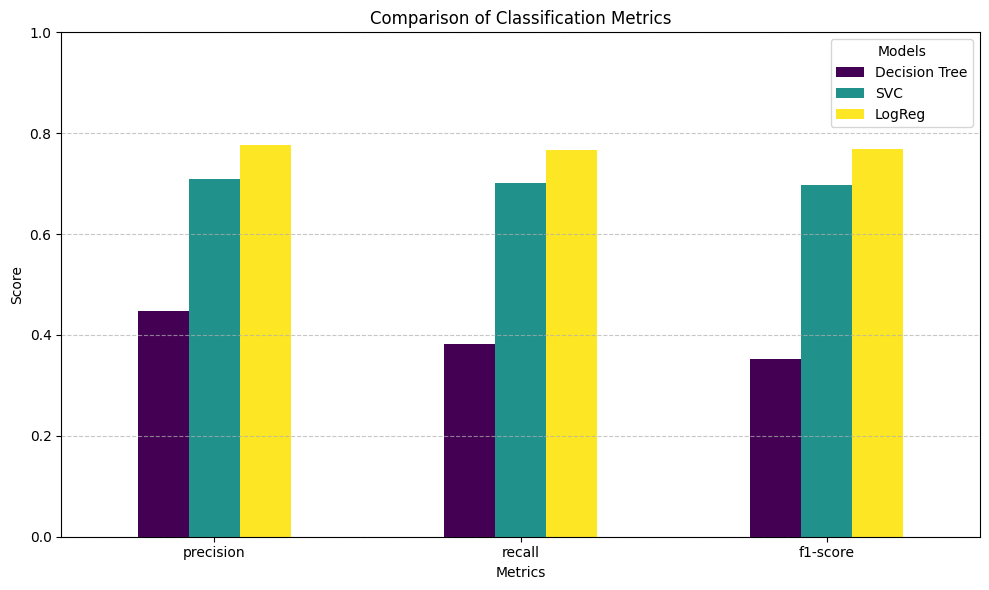

In [70]:
import matplotlib.pyplot as plt

report_dt = classification_report(y_test, y_pred_dt, output_dict=True, zero_division=0)
report_svc = classification_report(y_test, y_pred_SVC, output_dict=True, zero_division=0)
report_logreg = classification_report(y_test, y_pred_logreg, output_dict=True, zero_division=0)

# Выбираем метрики для визуализации
metrics = ['precision', 'recall', 'f1-score']
labels = ['Decision Tree', 'SVC', 'LogReg']

# Извлечение метрик
data = {
    'Decision Tree': [report_dt['macro avg'][metric] for metric in metrics],
    'SVC': [report_svc['macro avg'][metric] for metric in metrics],
    'LogReg': [report_logreg['macro avg'][metric] for metric in metrics]
}

# Создание DataFrame для удобства работы
df = pd.DataFrame(data, index=metrics)

# Построение гистограммы
df.plot(kind='bar', figsize=(10, 6), colormap='viridis')
plt.title('Comparison of Classification Metrics')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(title='Models')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### Эвристики + текстовые признаки

Стоит отметить, что эвиристики и текстовые признаки векторизации имеют разную природу. Это значит, что при необходимости стандартизации нужно рассматривать наборы фичей отдельно.

In [75]:
X_heur_train, X_heur_test, X_bow_train, X_bow_test, y_train, y_test = train_test_split(X_heuristics, X_bow, y, test_size=0.2, random_state=42)

In [76]:
# Стандартизация эвристик
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_heur_train)
X_test_scaled = scaler.transform(X_heur_test)

In [77]:
# Формирование итоговых датасетов
X_train_combined = np.hstack([X_train_scaled, X_bow_train.toarray()])
X_test_combined = np.hstack([X_test_scaled, X_bow_test.toarray()])

In [78]:
X_train_combined.shape

(2052, 504)

Теперь у нас $4$ эвристики и $500$ текстовых фичей.

In [79]:
# Инициализация и обучение моделей
model_SVC = SVC(kernel='linear', random_state=42)
model_logreg = LogisticRegression(random_state=42, max_iter=1000)
model_dt = DecisionTreeClassifier(max_depth=5, random_state=42)

model_SVC.fit(X_train_combined, y_train)
model_logreg.fit(X_train_combined, y_train)
model_dt.fit(X_train_combined, y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [80]:
# Предсказания
y_pred_SVC = model_SVC.predict(X_test_combined)
y_pred_logreg = model_logreg.predict(X_test_combined)
y_pred_dt = model_dt.predict(X_test_combined)

##### Метрики качества:

###### SVC

In [81]:
# Оценка качества модели
# Accuracy
accuracy = accuracy_score(y_test, y_pred_SVC)
print("Accuracy:", accuracy)

# Precision, Recall, F1 (взвешенные для многоклассовой задачи)
precision = precision_score(y_test, y_pred_SVC, average='weighted')
recall = recall_score(y_test, y_pred_SVC, average='weighted')
f1 = f1_score(y_test, y_pred_SVC, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Матрица ошибок
conf_matrix = confusion_matrix(y_test, y_pred_SVC)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.8245614035087719
Precision: 0.8471696614088091
Recall: 0.8245614035087719
F1 Score: 0.8305615174248677
Confusion Matrix:
 [[12  2  0  0  1  0  4  0  0  0  1  0  1]
 [ 4 41  0  0  1  0  1  0  1  0  2  0  0]
 [ 7  1 25  0  0  0  1  1  0  0  2  1  0]
 [ 0  0  0 36  0  0  2  1  0  0  4  2  0]
 [ 0  2  0  0  7  0  2  0  0  1  0  0  1]
 [ 2  0  0  0  0 54  0  1  2  0  0  0  0]
 [ 2  3  0  0  1  0 69  2  1  0  0  0  0]
 [ 1  1  0  0  0  0  0  4  1  0  0  0  0]
 [ 0  0  0  1  0  0  3  0 48  0  1  0  0]
 [ 2  2  0  0  1  0  0  0  0 23  0  0  0]
 [ 0  1  0  0  1  0  1  0  0  0 32  1  0]
 [ 3  0  1  1  0  0  0  1  1  0  0 54  0]
 [ 0  2  0  0  0  0  1  0  0  2  1  0 18]]


In [82]:
# Полный отчет
print("\nClassification Report:")
print(classification_report(y_test, y_pred_SVC))


Classification Report:
                                   precision    recall  f1-score   support

     Блок Александр Александрович       0.36      0.57      0.44        21
            Бунин Иван Алексеевич       0.75      0.82      0.78        50
        Гоголь Николай Васильевич       0.96      0.66      0.78        38
     Достоевский Федор Михайлович       0.95      0.80      0.87        45
      Есенин Сергей Александрович       0.58      0.54      0.56        13
      Карамзин Николай Михайлович       1.00      0.92      0.96        59
        Куприн Александр Иванович       0.82      0.88      0.85        78
         Лермонтов Михаил Юрьевич       0.40      0.57      0.47         7
 Мамин-Сибиряк Дмитрий Наркисович       0.89      0.91      0.90        53
       Пушкин Александр Сергеевич       0.88      0.82      0.85        28
Салтыков-Щедрин Михаил Евграфович       0.74      0.89      0.81        36
          Тургенев Иван Сергеевич       0.93      0.89      0.91        61


###### LogisticRegression

In [83]:
# Оценка качества модели
# Accuracy
accuracy = accuracy_score(y_test, y_pred_logreg)
print("Accuracy:", accuracy)

# Precision, Recall, F1 (взвешенные для многоклассовой задачи)
precision = precision_score(y_test, y_pred_logreg, average='weighted')
recall = recall_score(y_test, y_pred_logreg, average='weighted')
f1 = f1_score(y_test, y_pred_logreg, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Матрица ошибок
conf_matrix = confusion_matrix(y_test, y_pred_logreg)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.8635477582846004
Precision: 0.8691767442462354
Recall: 0.8635477582846004
F1 Score: 0.8646268448520311
Confusion Matrix:
 [[14  2  0  0  3  1  1  0  0  0  0  0  0]
 [ 0 41  0  0  1  0  6  0  1  0  0  0  1]
 [ 1  0 33  0  1  1  0  1  0  0  0  1  0]
 [ 0  0  0 38  0  0  1  1  0  0  3  2  0]
 [ 0  1  0  0  8  0  3  0  0  0  0  0  1]
 [ 1  0  0  1  0 56  0  1  0  0  0  0  0]
 [ 1  3  0  0  0  0 72  1  0  0  0  0  1]
 [ 0  0  0  0  0  0  1  5  0  0  0  0  1]
 [ 1  0  0  1  0  0  3  0 47  0  1  0  0]
 [ 0  0  0  0  0  0  1  1  0 25  1  0  0]
 [ 0  0  0  2  0  0  1  0  0  0 32  1  0]
 [ 2  1  1  0  0  1  0  0  0  0  1 55  0]
 [ 0  2  1  0  0  0  2  0  0  2  0  0 17]]


In [84]:
# Полный отчет
print("\nClassification Report:")
print(classification_report(y_test, y_pred_logreg))


Classification Report:
                                   precision    recall  f1-score   support

     Блок Александр Александрович       0.70      0.67      0.68        21
            Бунин Иван Алексеевич       0.82      0.82      0.82        50
        Гоголь Николай Васильевич       0.94      0.87      0.90        38
     Достоевский Федор Михайлович       0.90      0.84      0.87        45
      Есенин Сергей Александрович       0.62      0.62      0.62        13
      Карамзин Николай Михайлович       0.95      0.95      0.95        59
        Куприн Александр Иванович       0.79      0.92      0.85        78
         Лермонтов Михаил Юрьевич       0.50      0.71      0.59         7
 Мамин-Сибиряк Дмитрий Наркисович       0.98      0.89      0.93        53
       Пушкин Александр Сергеевич       0.93      0.89      0.91        28
Салтыков-Щедрин Михаил Евграфович       0.84      0.89      0.86        36
          Тургенев Иван Сергеевич       0.93      0.90      0.92        61


###### DecisionTreeClassifier

In [85]:
# Оценка качества модели
# Accuracy
accuracy = accuracy_score(y_test, y_pred_dt)
print("Accuracy:", accuracy)

# Precision, Recall, F1 (взвешенные для многоклассовой задачи)
precision = precision_score(y_test, y_pred_dt, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred_dt, average='weighted')
f1 = f1_score(y_test, y_pred_dt, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Матрица ошибок
conf_matrix = confusion_matrix(y_test, y_pred_dt)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.7485380116959064
Precision: 0.6800870353271091
Recall: 0.7485380116959064
F1 Score: 0.6965201375213945
Confusion Matrix:
 [[ 0  0 21  0  0  0  0  0  0  0  0  0  0]
 [ 0 50  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 38  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 45  0  0  0  0  0  0  0  0  0]
 [ 0  0 13  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 59  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 78  0  0  0  0  0  0]
 [ 0  7  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 53  0  0  0  0]
 [ 0  0 28  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 36  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 61  0]
 [ 0  0 24  0  0  0  0  0  0  0  0  0  0]]


In [86]:
# Полный отчет
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt, zero_division=0))


Classification Report:
                                   precision    recall  f1-score   support

     Блок Александр Александрович       0.00      0.00      0.00        21
            Бунин Иван Алексеевич       0.88      1.00      0.93        50
        Гоголь Николай Васильевич       0.24      1.00      0.38        38
     Достоевский Федор Михайлович       1.00      1.00      1.00        45
      Есенин Сергей Александрович       0.00      0.00      0.00        13
      Карамзин Николай Михайлович       1.00      1.00      1.00        59
        Куприн Александр Иванович       1.00      1.00      1.00        78
         Лермонтов Михаил Юрьевич       0.00      0.00      0.00         7
 Мамин-Сибиряк Дмитрий Наркисович       1.00      1.00      1.00        53
       Пушкин Александр Сергеевич       0.00      0.00      0.00        28
Салтыков-Щедрин Михаил Евграфович       0.00      0.00      0.00        36
          Тургенев Иван Сергеевич       1.00      1.00      1.00        61


##### Сводка по метрикам качества

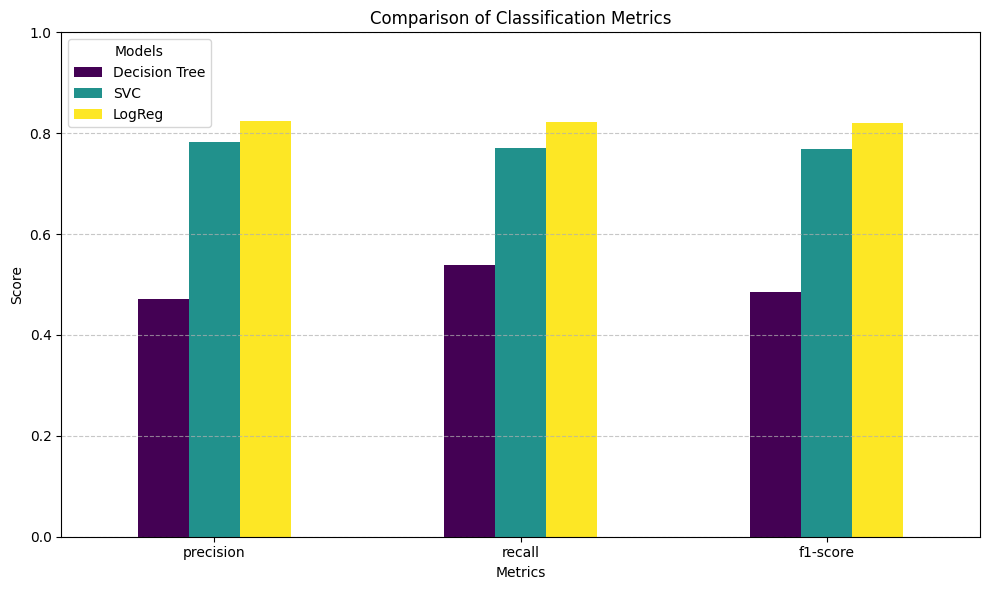

In [87]:
report_dt = classification_report(y_test, y_pred_dt, output_dict=True, zero_division=0)
report_svc = classification_report(y_test, y_pred_SVC, output_dict=True, zero_division=0)
report_logreg = classification_report(y_test, y_pred_logreg, output_dict=True, zero_division=0)

# Выбираем метрики для визуализации
metrics = ['precision', 'recall', 'f1-score']
labels = ['Decision Tree', 'SVC', 'LogReg']

# Извлечение метрик
data = {
    'Decision Tree': [report_dt['macro avg'][metric] for metric in metrics],
    'SVC': [report_svc['macro avg'][metric] for metric in metrics],
    'LogReg': [report_logreg['macro avg'][metric] for metric in metrics]
}

# Создание DataFrame для удобства работы
df = pd.DataFrame(data, index=metrics)

# Построение гистограммы
df.plot(kind='bar', figsize=(10, 6), colormap='viridis')
plt.title('Comparison of Classification Metrics')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(title='Models')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()